<a href="https://colab.research.google.com/github/mhsnur/TESIS-S2-Geomatika-FT-UGM-Muhsin-Nur-Alamsyah/blob/main/BO_DBSCAN/DBSCAN_GSP_UGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 9.2 MB/s eta 0:00:00


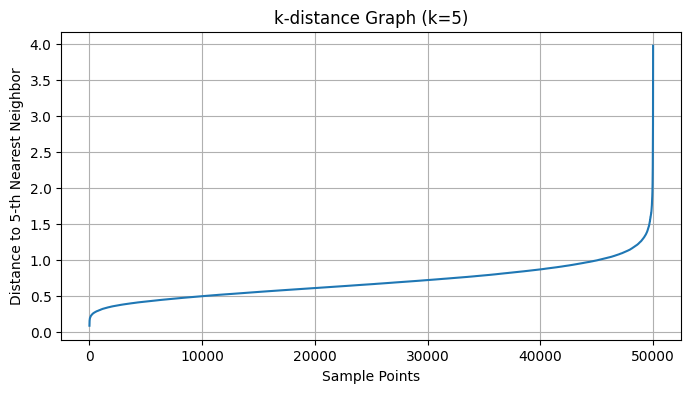

In [ ]:

!pip install laspy scikit-learn matplotlib

import laspy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


las = laspy.read("/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/ATAP_BANGUNAN.las")  # Ganti path jika perlu
points = np.vstack((las.x, las.y, las.z)).T

sample_size = min(50000, len(points))
sample_idx = np.random.choice(len(points), size=sample_size, replace=False)
sample = points[sample_idx]

k = 5  # Jumlah tetangga
nbrs = NearestNeighbors(n_neighbors=k).fit(sample)
distances, _ = nbrs.kneighbors(sample)
k_distances = np.sort(distances[:, k-1])


plt.figure(figsize=(8, 4))
plt.plot(k_distances)
plt.title(f"k-distance Graph (k={k})")
plt.xlabel("Sample Points")
plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
plt.grid(True)
plt.show()


Estimated eps: 0.965
Jumlah cluster ditemukan: 32
Jumlah noise points: 56 dari total 2868169


/tmp/ipython-input-36687593.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


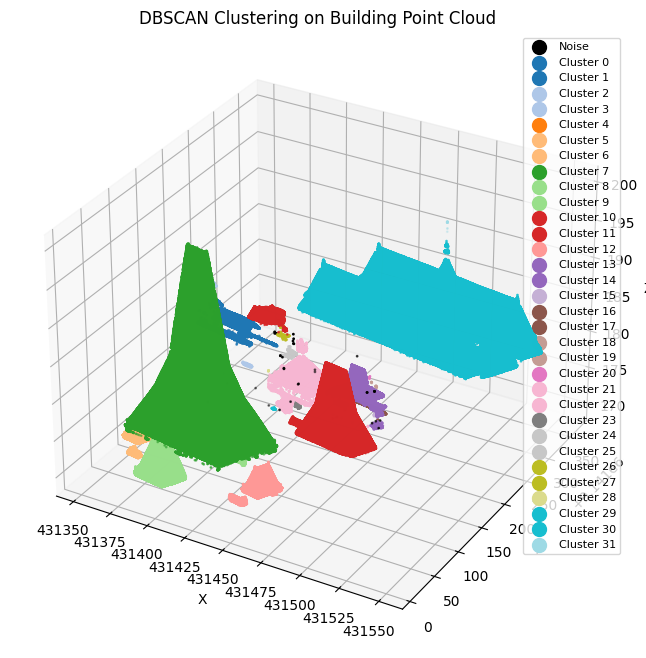

/tmp/ipython-input-36687593.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


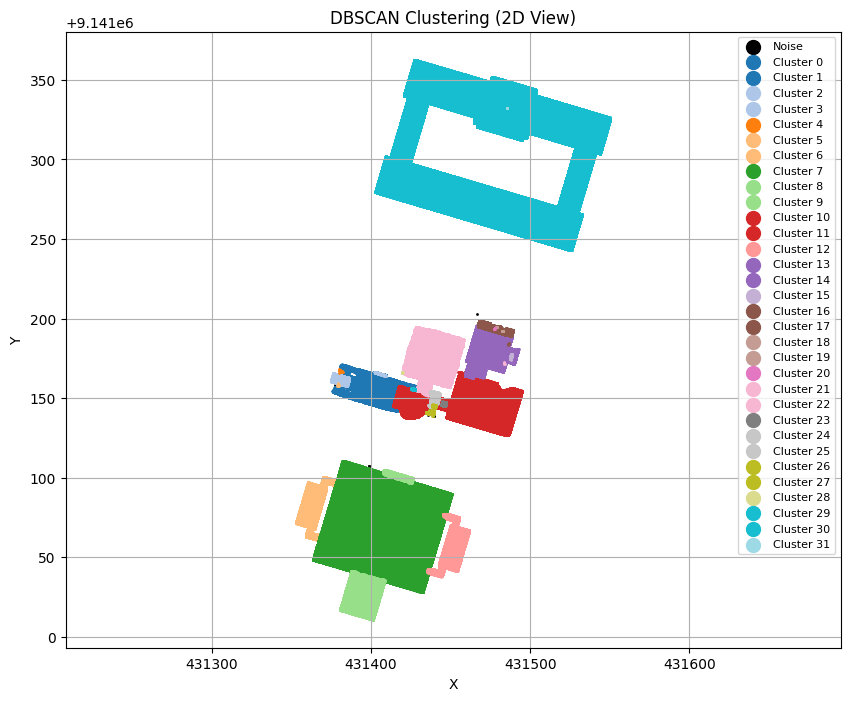

In [ ]:

eps_auto = np.percentile(k_distances, 88)
print(f"Estimated eps: {eps_auto:.3f}")


db = DBSCAN(eps=eps_auto, min_samples=k).fit(points)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

print(f"Jumlah cluster ditemukan: {n_clusters}")
print(f"Jumlah noise points: {n_noise} dari total {len(labels)}")


from mpl_toolkits.mplot3d import Axes3D

def visualize_clusters_matplotlib(points, labels):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(labels)
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    for label in unique_labels:
        color = 'k' if label == -1 else cmap(label)
        mask = labels == label
        cluster = points[mask]
        ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2],
                   c=[color], s=1, label=f'Cluster {label}' if label != -1 else 'Noise')

    ax.set_title('DBSCAN Clustering on Building Point Cloud')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(loc='upper right', markerscale=10, fontsize=8)
    plt.show()

visualize_clusters_matplotlib(points, labels)


def visualize_clusters_2d(points, labels):
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(labels)
    cmap = plt.cm.get_cmap('tab20', len(unique_labels))

    for label in unique_labels:
        color = 'k' if label == -1 else cmap(label)
        mask = labels == label
        cluster = points[mask]
        plt.scatter(cluster[:, 0], cluster[:, 1],
                    c=[color], s=1, label=f'Cluster {label}' if label != -1 else 'Noise')

    plt.title('DBSCAN Clustering (2D View)')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(markerscale=10, fontsize=8, loc='upper right')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Panggil fungsi visualisasi 2D
visualize_clusters_2d(points, labels)


In [ ]:
!pip install alphashape shapely matplotlib

import matplotlib.pyplot as plt
import alphashape
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.cm as cm

def outline_with_void_detection_fixed(points, labels, alpha=1, min_hole_area=3.0):
    unique_labels = [l for l in np.unique(labels) if l != -1]
    outlines = []

    colors = cm.get_cmap('tab20', len(unique_labels))

    plt.figure(figsize=(12, 12))

    for i, label in enumerate(unique_labels):
        cluster_points = points[labels == label][:, :2]

        if len(cluster_points) < 4:
            continue

        try:
            shape = alphashape.alphashape(cluster_points, alpha)

            color = colors(i)

            # Polygon tunggal
            if isinstance(shape, Polygon):
                outlines.append((label, shape))
                x, y = shape.exterior.xy
                plt.plot(x, y, color=color, linewidth=2, label=f"Cluster {label}")

                for interior in shape.interiors:
                    if Polygon(interior).area > min_hole_area:
                        xh, yh = interior.xy
                        plt.plot(xh, yh, color='red', linewidth=1.5, linestyle='--')

            # MultiPolygon
            elif isinstance(shape, MultiPolygon):
                for poly in shape.geoms:
                    outlines.append((label, poly))
                    x, y = poly.exterior.xy
                    plt.plot(x, y, color=color, linewidth=2, label=f"Cluster {label}")

                    for interior in poly.interiors:
                        if Polygon(interior).area > min_hole_area:
                            xh, yh = interior.xy
                            plt.plot(xh, yh, color='red', linewidth=1.5, linestyle='--')

        except Exception as e:
            print(f"⚠️ Gagal alphashape untuk Cluster {label}: {e}")
            continue

    plt.title("Outline Alphashape + Deteksi Void (DBSCAN)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.legend(fontsize=8, loc='best')
    plt.show()

    return outlines


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 61.2 MB/s eta 0:00:00


/tmp/ipython-input-1382009511.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_labels))


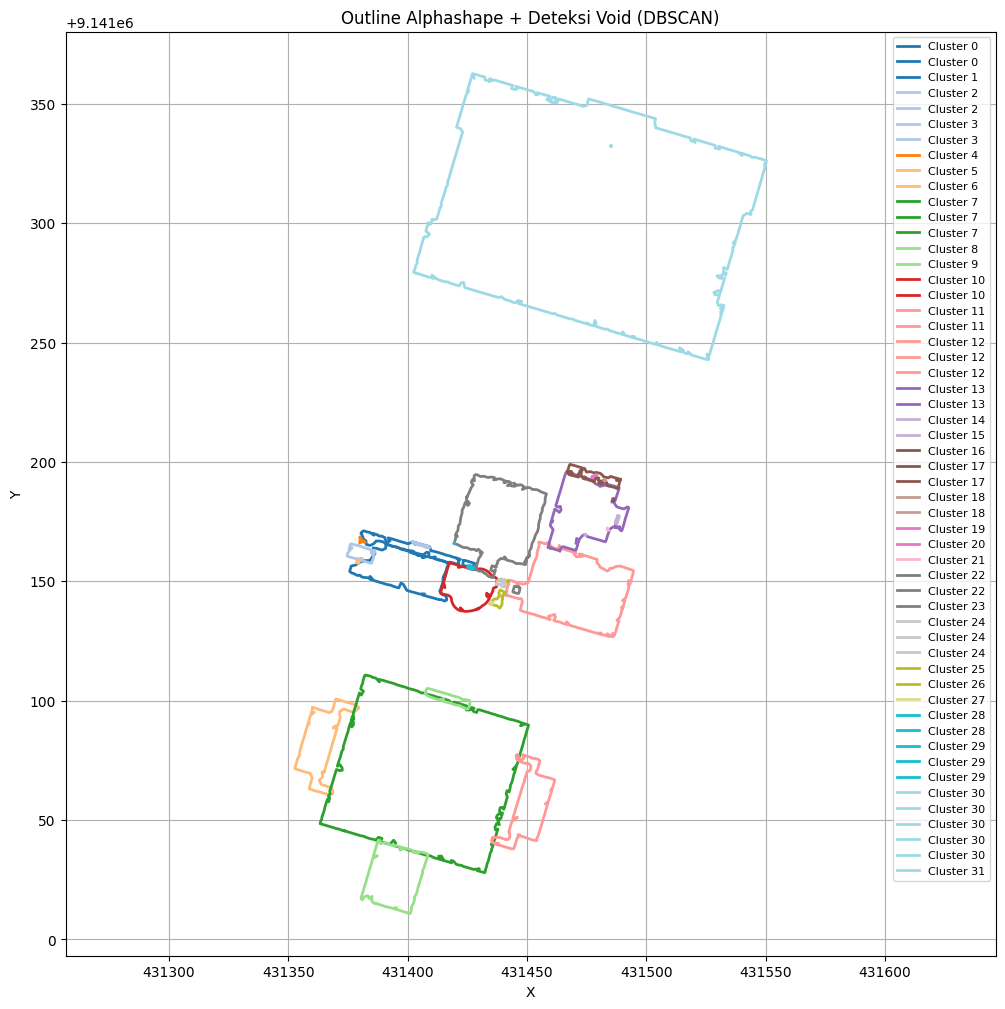

In [ ]:
outlines_fixed = outline_with_void_detection_fixed(points, labels, alpha=0.82, min_hole_area=2.0)


In [ ]:
!pip install geopandas shapely fiona pyproj rtree --quiet
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon

output_geojson = "/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/GSP_outline.geojson"

records = []
for label, geom in outlines_fixed:
    if isinstance(geom, (Polygon, MultiPolygon)):
        records.append({
            "cluster_id": label,
            "geometry": geom
        })

gdf = gpd.GeoDataFrame(records, crs="EPSG:32749")
gdf.to_file(output_geojson, driver="GeoJSON")

print("✅ DBSCAN Alphashape exported!")
print("📂 File saved at:", output_geojson)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 112.0 MB/s eta 0:00:00
✅ DBSCAN Alphashape exported!
📂 File saved at: /content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_2x_RF/GSP_outline.geojson


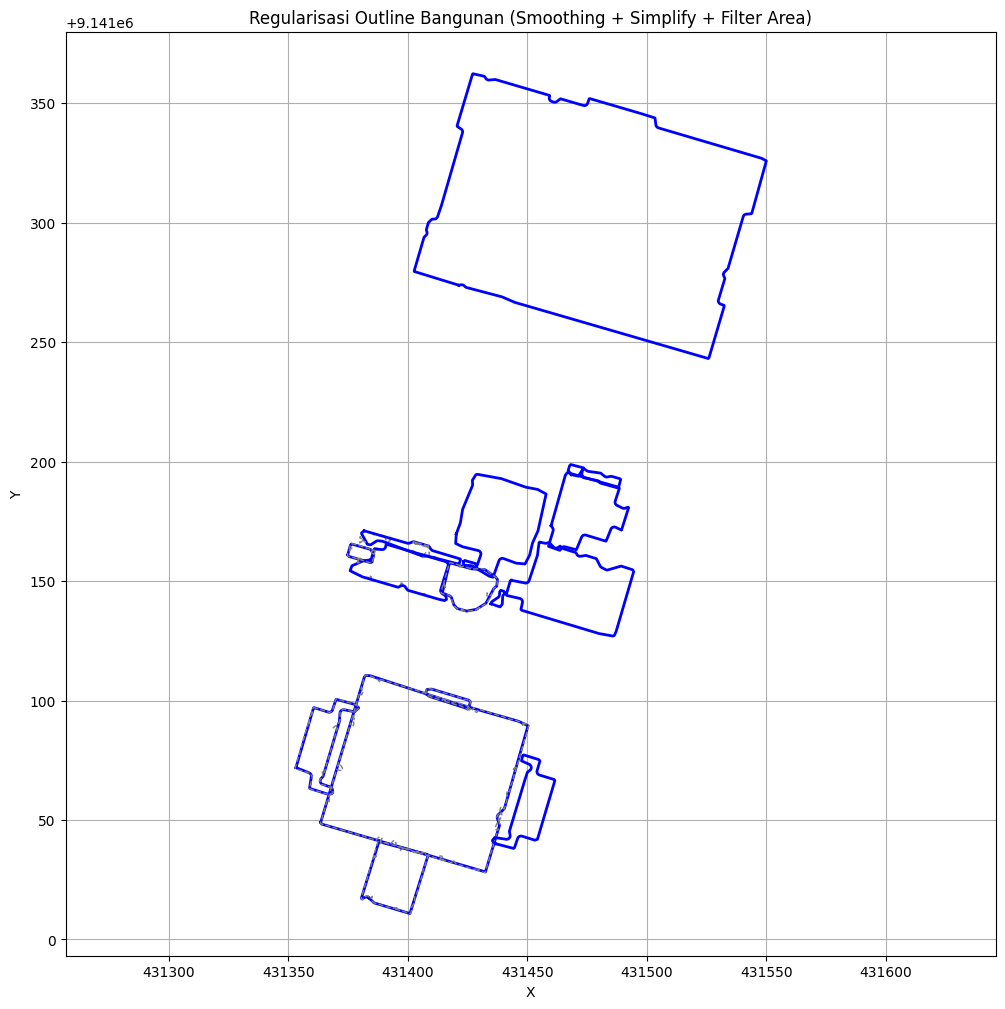

In [ ]:
# ============================================
# REGULARISASI OUTLINE BANGUNAN (LANJUTAN)
# ============================================
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

def regularisasi_outline(outlines, smooth_buffer=0.5, simplify_tol=0.3, min_area=5.0):
    regularized_outlines = []

    for label, poly in outlines:
        if not isinstance(poly, Polygon):
            continue
        if poly.area < min_area:
            continue

        # 1️⃣ Smoothing dengan buffer positif-negatif
        smoothed = poly.buffer(smooth_buffer)

        # 2️⃣ Simplifikasi untuk kurangi vertex kecil
        simplified = smoothed.simplify(simplify_tol, preserve_topology=True)

        # 3️⃣ Buffer negatif untuk kembalikan bentuk
        final_poly = simplified.buffer(-smooth_buffer)

        # 4️⃣ Filter area kecil setelah regularisasi
        if final_poly.area > min_area:
            regularized_outlines.append((label, final_poly))

    return regularized_outlines


# ============================================
# VISUALISASI HASIL REGULARISASI
# ============================================
def plot_regularisasi(original_outlines, regularized_outlines):
    plt.figure(figsize=(12, 12))

    for (label, orig_poly), (_, reg_poly) in zip(original_outlines, regularized_outlines):
        if not orig_poly.is_valid or not reg_poly.is_valid:
            continue

        x1, y1 = orig_poly.exterior.xy
        x2, y2 = reg_poly.exterior.xy

        plt.plot(x1, y1, color='gray', linestyle='--', linewidth=1)
        plt.plot(x2, y2, color='blue', linewidth=2)

    plt.title("Regularisasi Outline Bangunan (Smoothing + Simplify + Filter Area)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.show()


# ============================================
# EKSEKUSI REGULARISASI
# ============================================
regularized_outlines = regularisasi_outline(
    outlines_fixed,      # ✅ gunakan variabel dari alphashape Anda
    smooth_buffer=1.5,
    simplify_tol=0.,
    min_area=8.0         # Buang poligon kecil (noise)
)

plot_regularisasi(outlines_fixed, regularized_outlines)


NameError: name 'outlines_fixed' is not defined

In [ ]:
from shapely.geometry import LineString
from shapely.ops import unary_union, snap
from shapely.affinity import rotate
import math

def regularize_outline(polygons, angle_threshold=15, simplify_tolerance=0.5):
    """
    Regularisasi outline dengan menyederhanakan dan memperbaiki sudut agar mendekati 90 derajat.
    """
    regularized_polygons = []

    for label, poly in polygons:
        # Step 1: Simplify to remove small noise
        simplified = poly.simplify(simplify_tolerance, preserve_topology=True)

        # Step 2: Snap sudut agar lebih lurus
        coords = list(simplified.exterior.coords)
        new_coords = [coords[0]]

        for i in range(1, len(coords)-1):
            prev_pt = np.array(new_coords[-1])
            curr_pt = np.array(coords[i])
            next_pt = np.array(coords[i+1])

            v1 = curr_pt - prev_pt
            v2 = next_pt - curr_pt

            angle = np.degrees(np.arccos(np.clip(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)), -1.0, 1.0)))

            # Jika sudut mendekati 90 derajat, pertahankan
            if abs(angle - 90) < angle_threshold or abs(angle - 270) < angle_threshold:
                new_coords.append(tuple(curr_pt))
            else:
                # Jika tidak, lewati titik ini (anggap sebagai noise)
                continue

        # Tambahkan titik terakhir
        new_coords.append(coords[-1])

        # Buat ulang poligon
        if len(new_coords) >= 4:
            reg_poly = Polygon(new_coords)
            if reg_poly.is_valid and reg_poly.area > 1.0:
                regularized_polygons.append((label, reg_poly))

    return regularized_polygons


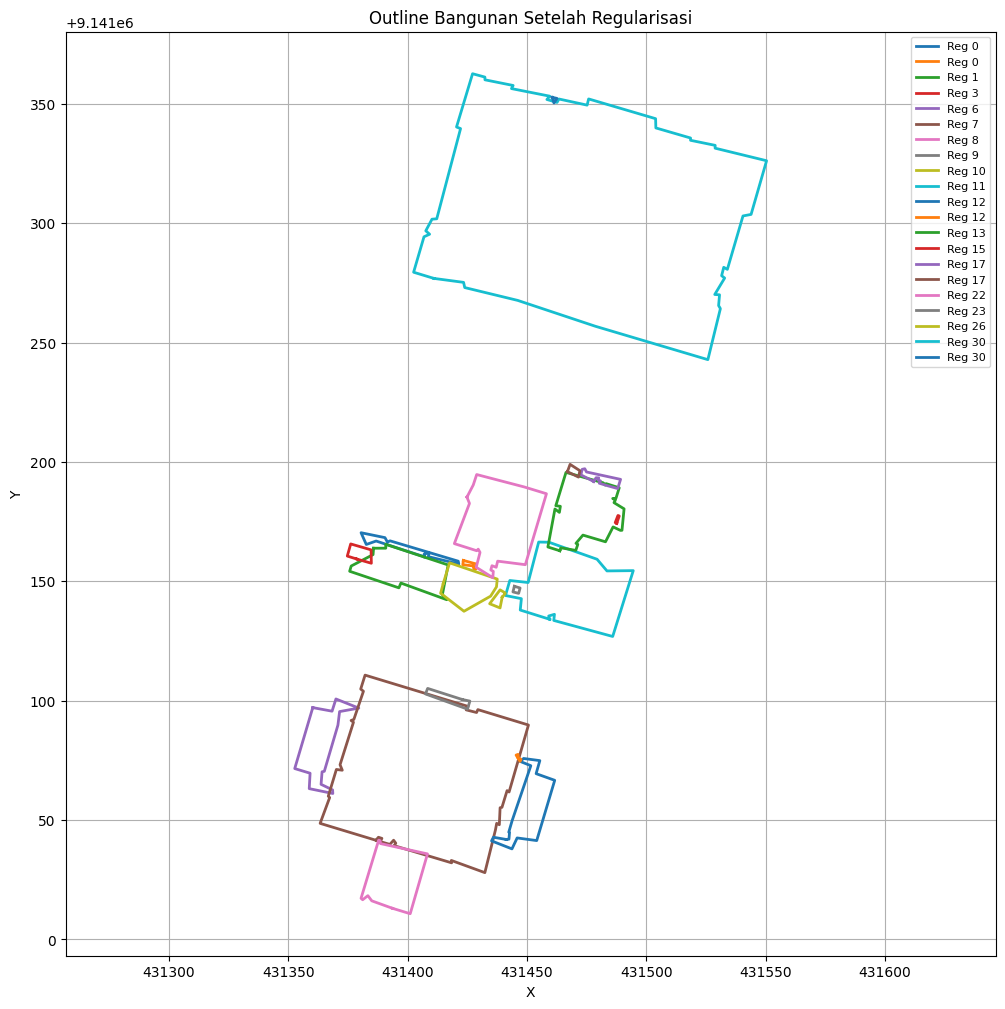

In [ ]:
def plot_regularized_polygons(polygons):
    plt.figure(figsize=(12, 12))
    for label, poly in polygons:
        x, y = poly.exterior.xy
        plt.plot(x, y, label=f"Reg {label}", linewidth=2)

    plt.title("Outline Bangunan Setelah Regularisasi")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.show()
regularized_outlines = regularize_outline(outlines_fixed, angle_threshold=30, simplify_tolerance=0.2)
plot_regularized_polygons(regularized_outlines)


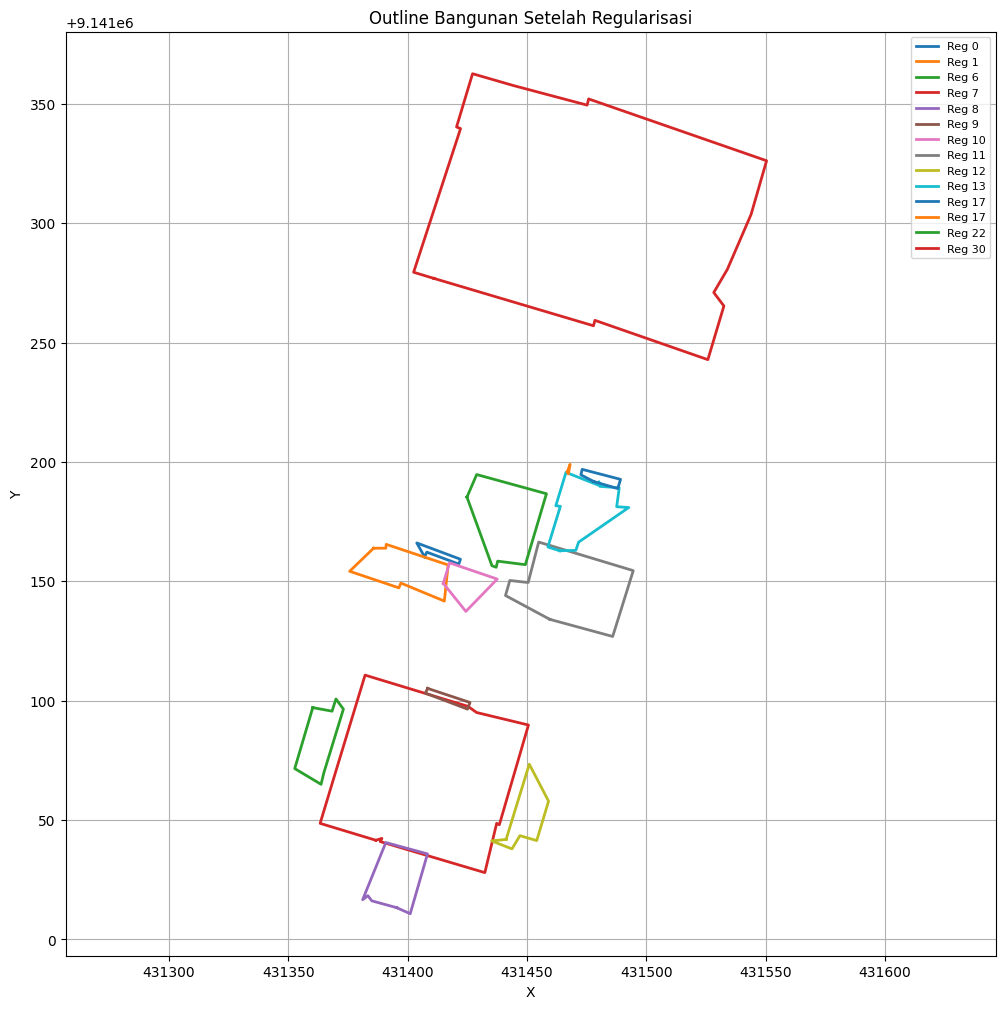

In [ ]:
!pip install geopandas shapely fiona pyproj


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 134.2 MB/s eta 0:00:00


In [ ]:
import geopandas as gpd
from shapely.geometry import Polygon
import os


In [ ]:
def save_alphashape_outlines(outlines, output_path_base):
    """
    outlines: list of (label, shapely Polygon or MultiPolygon)
    output_path_base: contoh '/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_alphashape_outline'
    """
    import geopandas as gpd
    from shapely.geometry import Polygon, MultiPolygon
    import os

    # Buat GeoDataFrame
    records = []
    for label, geom in outlines:
        if isinstance(geom, (Polygon, MultiPolygon)):
            records.append({
                'cluster_id': label,
                'geometry': geom
            })

    gdf = gpd.GeoDataFrame(records, crs="EPSG:32748")  # Ganti CRS jika perlu

    # Simpan GeoJSON
    geojson_path = output_path_base + ".geojson"
    gdf.to_file(geojson_path, driver="GeoJSON")
    print(f"✅ GeoJSON saved to: {geojson_path}")

    # Simpan Shapefile
    shp_dir = output_path_base + "_shp"
    os.makedirs(shp_dir, exist_ok=True)
    shp_path = os.path.join(shp_dir, "building_alphashape_outline.shp")
    gdf.to_file(shp_path)
    print(f"✅ Shapefile saved to: {shp_path}")


/tmp/ipython-input-2152447373.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(unique_labels))


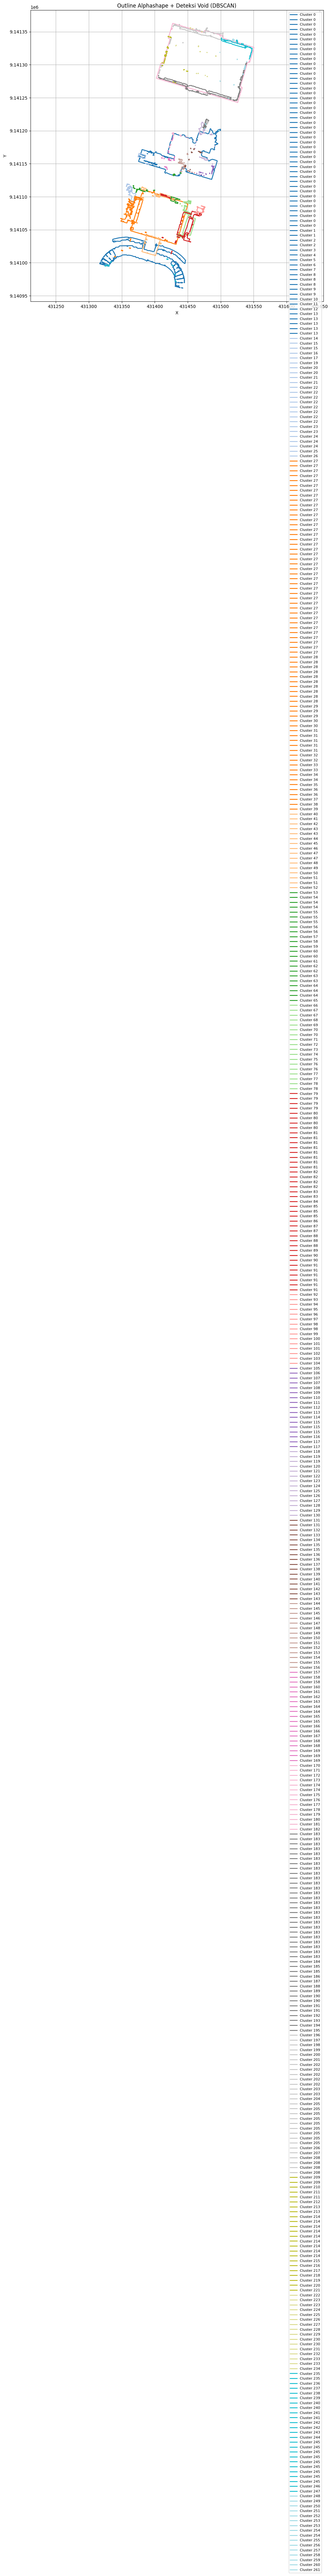

In [ ]:
alphashape_outlines = outline_with_void_detection_fixed(points, labels, alpha=0.8, min_hole_area=2.0)


In [ ]:
save_alphashape_outlines(
    outlines=alphashape_outlines,
    output_path_base="/content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_alphashape_outline"
)


✅ GeoJSON saved to: /content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_alphashape_outline.geojson
✅ Shapefile saved to: /content/drive/MyDrive/Segmented_LAS/DATA TESIS/building_alphashape_outline_shp/building_alphashape_outline.shp


In [ ]:
# DBSCAN Clustering
db = DBSCAN(eps=1.0, min_samples=30).fit(xy_points)
labels = db.labels_

# Hitung jumlah cluster valid
unique_labels = set(labels)
unique_labels.discard(-1)
print(f"Jumlah bangunan terdeteksi: {len(unique_labels)}")


Jumlah bangunan terdeteksi: 392


/tmp/ipython-input-3202157986.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))
/tmp/ipython-input-3202157986.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-3202157986.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


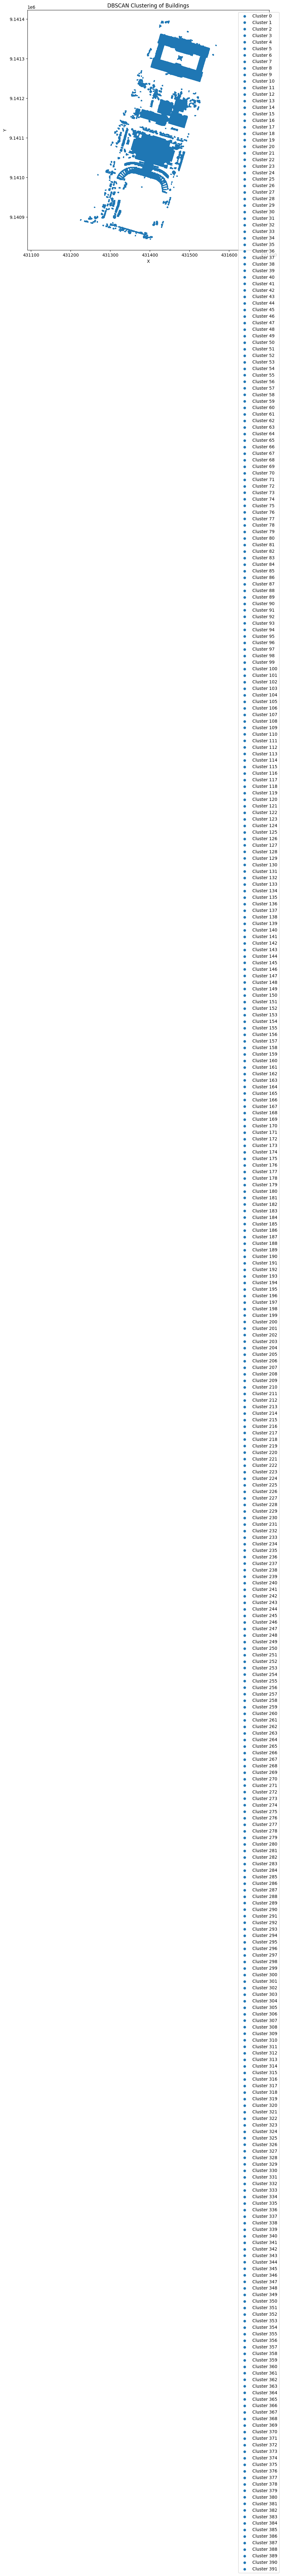

In [ ]:
# Warna berbeda per cluster
colors = plt.cm.get_cmap('tab20', len(unique_labels))

plt.figure(figsize=(10, 10))
for label in unique_labels:
    cluster = xy_points[labels == label]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=1, color=colors(label % 20), label=f'Cluster {label}')
plt.title("DBSCAN Clustering of Buildings")
plt.xlabel("X"); plt.ylabel("Y")
plt.axis('equal'); plt.legend(markerscale=5, bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [ ]:
# Ambil cluster dengan jumlah titik terbanyak
unique_labels, counts = np.unique(labels, return_counts=True)
cluster_id = unique_labels[np.argmax(counts)]
building_points = xy_points[labels == cluster_id]


In [ ]:
alpha = 0.7  # Atur untuk detail outline
outline = alphashape.alphashape(building_points, alpha)

if isinstance(outline, Polygon):
    x, y = outline.exterior.xy
    plt.figure(figsize=(8, 8))
    plt.scatter(building_points[:, 0], building_points[:, 1], s=1, alpha=0.3)
    plt.plot(x, y, color='blue', linewidth=2)
    plt.title("Alpha Shape Outline Bangunan")
    plt.axis('equal')
    plt.show()
else:
    print("Outline bukan polygon!")


/usr/local/lib/python3.12/dist-packages/alphashape/alphashape.py:79: UserWarning: Singular matrix. Likely caused by all points lying in an N-1 space.
  warnings.warn('Singular matrix. Likely caused by all points '


Outline bukan polygon!


In [ ]:
# Delaunay triangulasi
tri = Delaunay(building_points)
triangles = building_points[tri.simplices]
centroids = np.mean(triangles, axis=1)

# Deteksi lubang berdasarkan jarak ke titik terdekat
tree = cKDTree(building_points)
distances, _ = tree.query(centroids, k=1)
threshold = 1.0  # meter
mask_void = distances > threshold
void_triangles = triangles[mask_void]

# Gabungkan triangle jadi multipolygon
void_polygons = [Polygon(t) for t in void_triangles if Polygon(t).is_valid]
union_void = unary_union(void_polygons)

# Filter lubang yang ada di dalam outline
holes = []
if isinstance(union_void, Polygon):
    if outline.contains(union_void):
        holes.append(union_void.exterior.coords)
elif isinstance(union_void, MultiPolygon):
    for poly in union_void.geoms:
        if outline.contains(poly):
            holes.append(poly.exterior.coords)

# Buat polygon final dengan lubang
if isinstance(outline, Polygon):
    final_poly = Polygon(shell=outline.exterior.coords, holes=holes)
else:
    final_poly = outline  # fallback


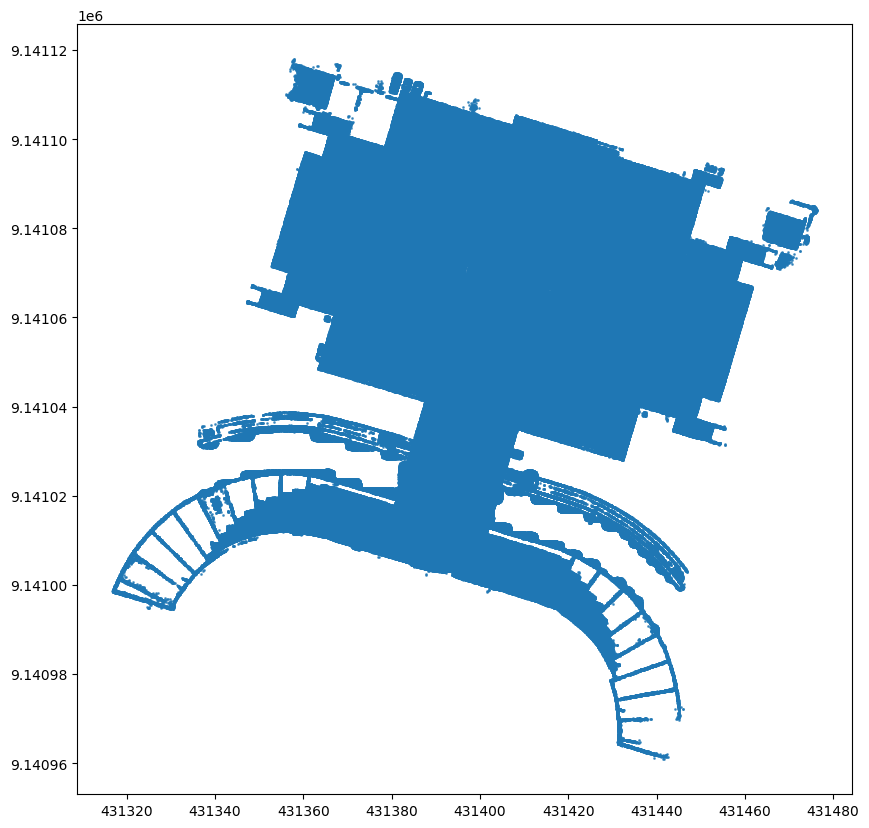

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


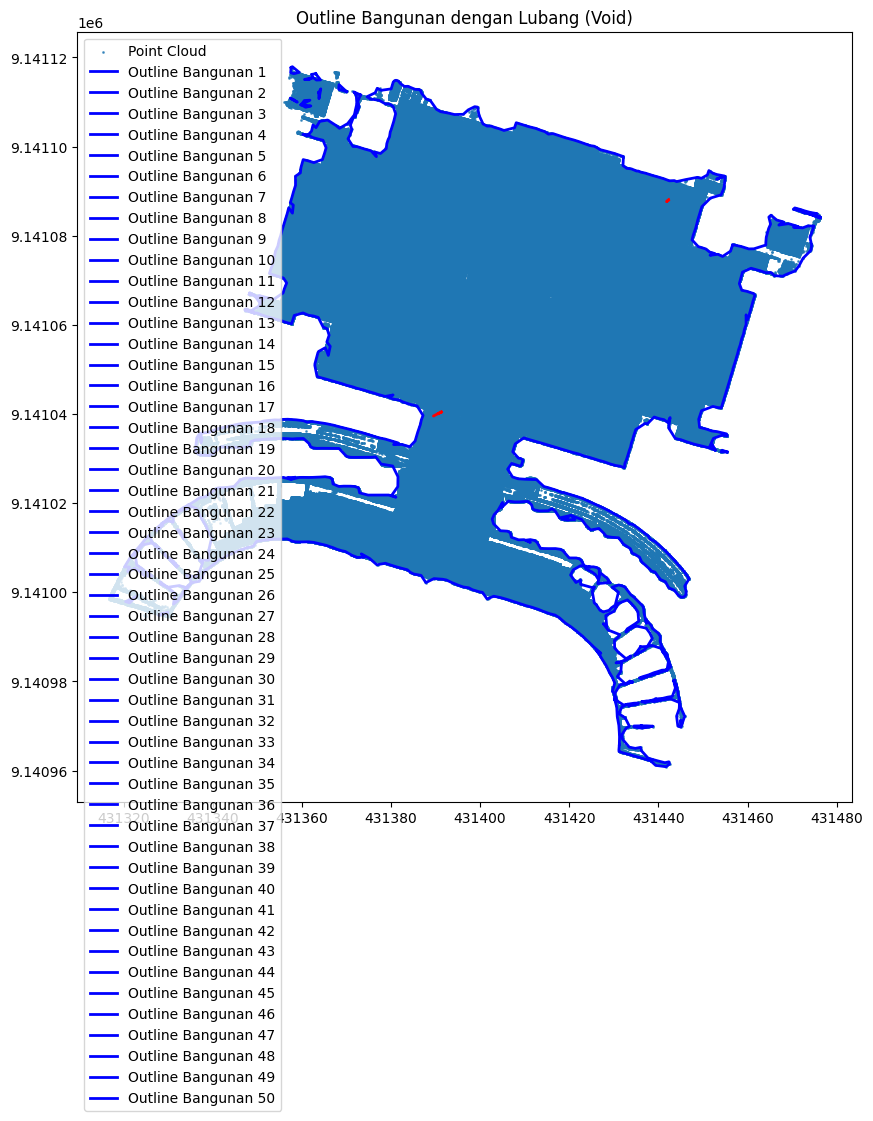

AttributeError: 'MultiPolygon' object has no attribute 'interiors'

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(building_points[:, 0], building_points[:, 1], s=1, alpha=0.7, label='Point Cloud')

# Outline
plt.figure(figsize=(10, 10))
plt.scatter(building_points[:, 0], building_points[:, 1], s=1, alpha=0.7, label='Point Cloud')

if isinstance(final_poly, Polygon):
    x, y = final_poly.exterior.xy
    plt.plot(x, y, color='blue', linewidth=2, label='Outline Bangunan')
    for i, hole in enumerate(final_poly.interiors):
        hx, hy = hole.xy
        plt.plot(hx, hy, color='red', linestyle='--', linewidth=2,
                 label='Lubang Dalam' if i == 0 else None)

elif isinstance(final_poly, MultiPolygon):
    for idx, poly in enumerate(final_poly.geoms):
        x, y = poly.exterior.xy
        plt.plot(x, y, color='blue', linewidth=2, label=f'Outline Bangunan {idx + 1}')
        for i, hole in enumerate(poly.interiors):
            hx, hy = hole.xy
            plt.plot(hx, hy, color='red', linestyle='--', linewidth=2,
                     label='Lubang Dalam' if i == 0 and idx == 0 else None)

plt.axis('equal')
plt.title("Outline Bangunan dengan Lubang (Void)")
plt.legend()
plt.show()


# Lubang
for i, hole in enumerate(final_poly.interiors):
    hx, hy = hole.xy
    plt.plot(hx, hy, color='red', linestyle='--', linewidth=2, label='Lubang Dalam' if i == 0 else None)

plt.axis('equal')
plt.legend()
plt.title("Outline Bangunan dengan Lubang")
plt.show()
